In [1]:
import json
import pickle
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
import xml.etree.ElementTree as ET

# Parse the XML file
tree = ET.parse("./dataset/cwe.xml")
root = tree.getroot()
ns = {"cwe": "http://cwe.mitre.org/cwe-7"} # Define namespace
cwe_dict = {weakness.get("ID"): weakness for weakness in root.findall(".//cwe:Weakness", ns)}

def find_parents_dict(cwe_id:str):    
    result = {"Pillar": [], "Class": [], "Base": [], "Variant": []}
    
    current_cwe_id = cwe_id
    while current_cwe_id:    
        # Find the Weakness element
        weakness = cwe_dict.get(current_cwe_id)
        if not weakness:
            return None  # If CWE is not found, stop the search

        abstraction = weakness.get("Abstraction")
        if (result.get(abstraction, None)) is not None:
            result[abstraction].append('CWE-'+current_cwe_id)
        
        # Check if the weakness abstraction is "Pillar"
        if abstraction == "Pillar": break

        # Find the Parent CWE (ChildOf relation)
        related_weaknesses = weakness.find("cwe:Related_Weaknesses", ns)
        if related_weaknesses is not None:
            for related in related_weaknesses.findall("cwe:Related_Weakness", ns):
                if related.get("Nature") == "ChildOf":
                    current_cwe_id = related.get("CWE_ID")
        else: break
    
    return result

In [3]:
with open('./dataset/test_pickles/test_non_vuln.pkl', 'rb') as file:
    non_vuln_df = pickle.load(file)
    
with open('./dataset/test_pickles/test_vuln.pkl', 'rb') as file:
    vuln_df = pickle.load(file)

# df = pd.concat([non_vuln_df, vuln_df], ignore_index=True)
    
print(len(non_vuln_df))
print(len(vuln_df))
# print(len(df))

90
450


In [4]:
with open('./result/non_vuln_code_results.json', 'r') as file:
    non_vuln_result = json.load(file)

with open('./result/vuln_code_results.json', 'r') as file:
    vuln_result = json.load(file)

print(len(non_vuln_result))
print(len(vuln_result))

360
1800


In [5]:
# Add Class to results

for r in non_vuln_result:
    r['class'] = 'non_vuln'

for r in vuln_result:
    file_id = r['file_change_id']
    class_cwe_series = vuln_df[vuln_df['file_change_id'] == file_id]['class']
    
    if not class_cwe_series.empty:  # Avoid IndexError
        class_cwe = class_cwe_series.iloc[0]  # Extract first value
        r['class'] = class_cwe
    else:
        r['class'] = class_cwe
        print(f"No match found for file_change_id: {file_id}")

In [6]:
def purify_results(results):
    # filter CWE-num only
    for result in results:
        cwe = result['result']['cwe']
        if cwe is not None:
            cwe_string = cwe.get('cwe_id', '')  # Ensure it's a string
            if 'CWE-' in cwe_string:
                match = re.search(r'CWE-\d+', cwe_string, re.IGNORECASE)
                if match:
                    result['result']['cwe']['cwe_id'] = match.group()  # Set valid CWE
                else:
                    result['result']['cwe']['cwe_id'] = 'unknown'  # Set default safe value
            else:
                result['result']['cwe']['cwe_id'] = 'unknown'  # Handle invalid cases

    return results

results = non_vuln_result + vuln_result
results = purify_results(results)

Unique Pred Labels
['CWE-116' 'CWE-119' 'CWE-120' 'CWE-122' 'CWE-129' 'CWE-134' 'CWE-190'
 'CWE-20' 'CWE-200' 'CWE-209' 'CWE-22' 'CWE-237' 'CWE-269' 'CWE-284'
 'CWE-285' 'CWE-295' 'CWE-310' 'CWE-319' 'CWE-327' 'CWE-331' 'CWE-338'
 'CWE-345' 'CWE-346' 'CWE-366' 'CWE-400' 'CWE-401' 'CWE-412' 'CWE-416'
 'CWE-426' 'CWE-434' 'CWE-444' 'CWE-476' 'CWE-482' 'CWE-484' 'CWE-502'
 'CWE-591' 'CWE-597' 'CWE-601' 'CWE-611' 'CWE-665' 'CWE-676' 'CWE-693'
 'CWE-703' 'CWE-732' 'CWE-74' 'CWE-754' 'CWE-759' 'CWE-78' 'CWE-788'
 'CWE-79' 'CWE-798' 'CWE-807' 'CWE-835' 'CWE-89' 'CWE-908' 'CWE-918'
 'CWE-93' 'CWE-937' 'CWE-94' 'CWE-95' 'CWE-98' 'non_vuln' 'unknown']
pred_class_labels
['CWE-116' 'CWE-1177' 'CWE-20' 'CWE-228' 'CWE-269' 'CWE-285' 'CWE-287'
 'CWE-311' 'CWE-327' 'CWE-330' 'CWE-345' 'CWE-346' 'CWE-400' 'CWE-404'
 'CWE-436' 'CWE-610' 'CWE-657' 'CWE-662' 'CWE-665' 'CWE-666' 'CWE-668'
 'CWE-669' 'CWE-670' 'CWE-673' 'CWE-74' 'CWE-754' 'CWE-755' 'CWE-834'
 'CWE-913' 'non_vuln' 'unknown']
true_class_label

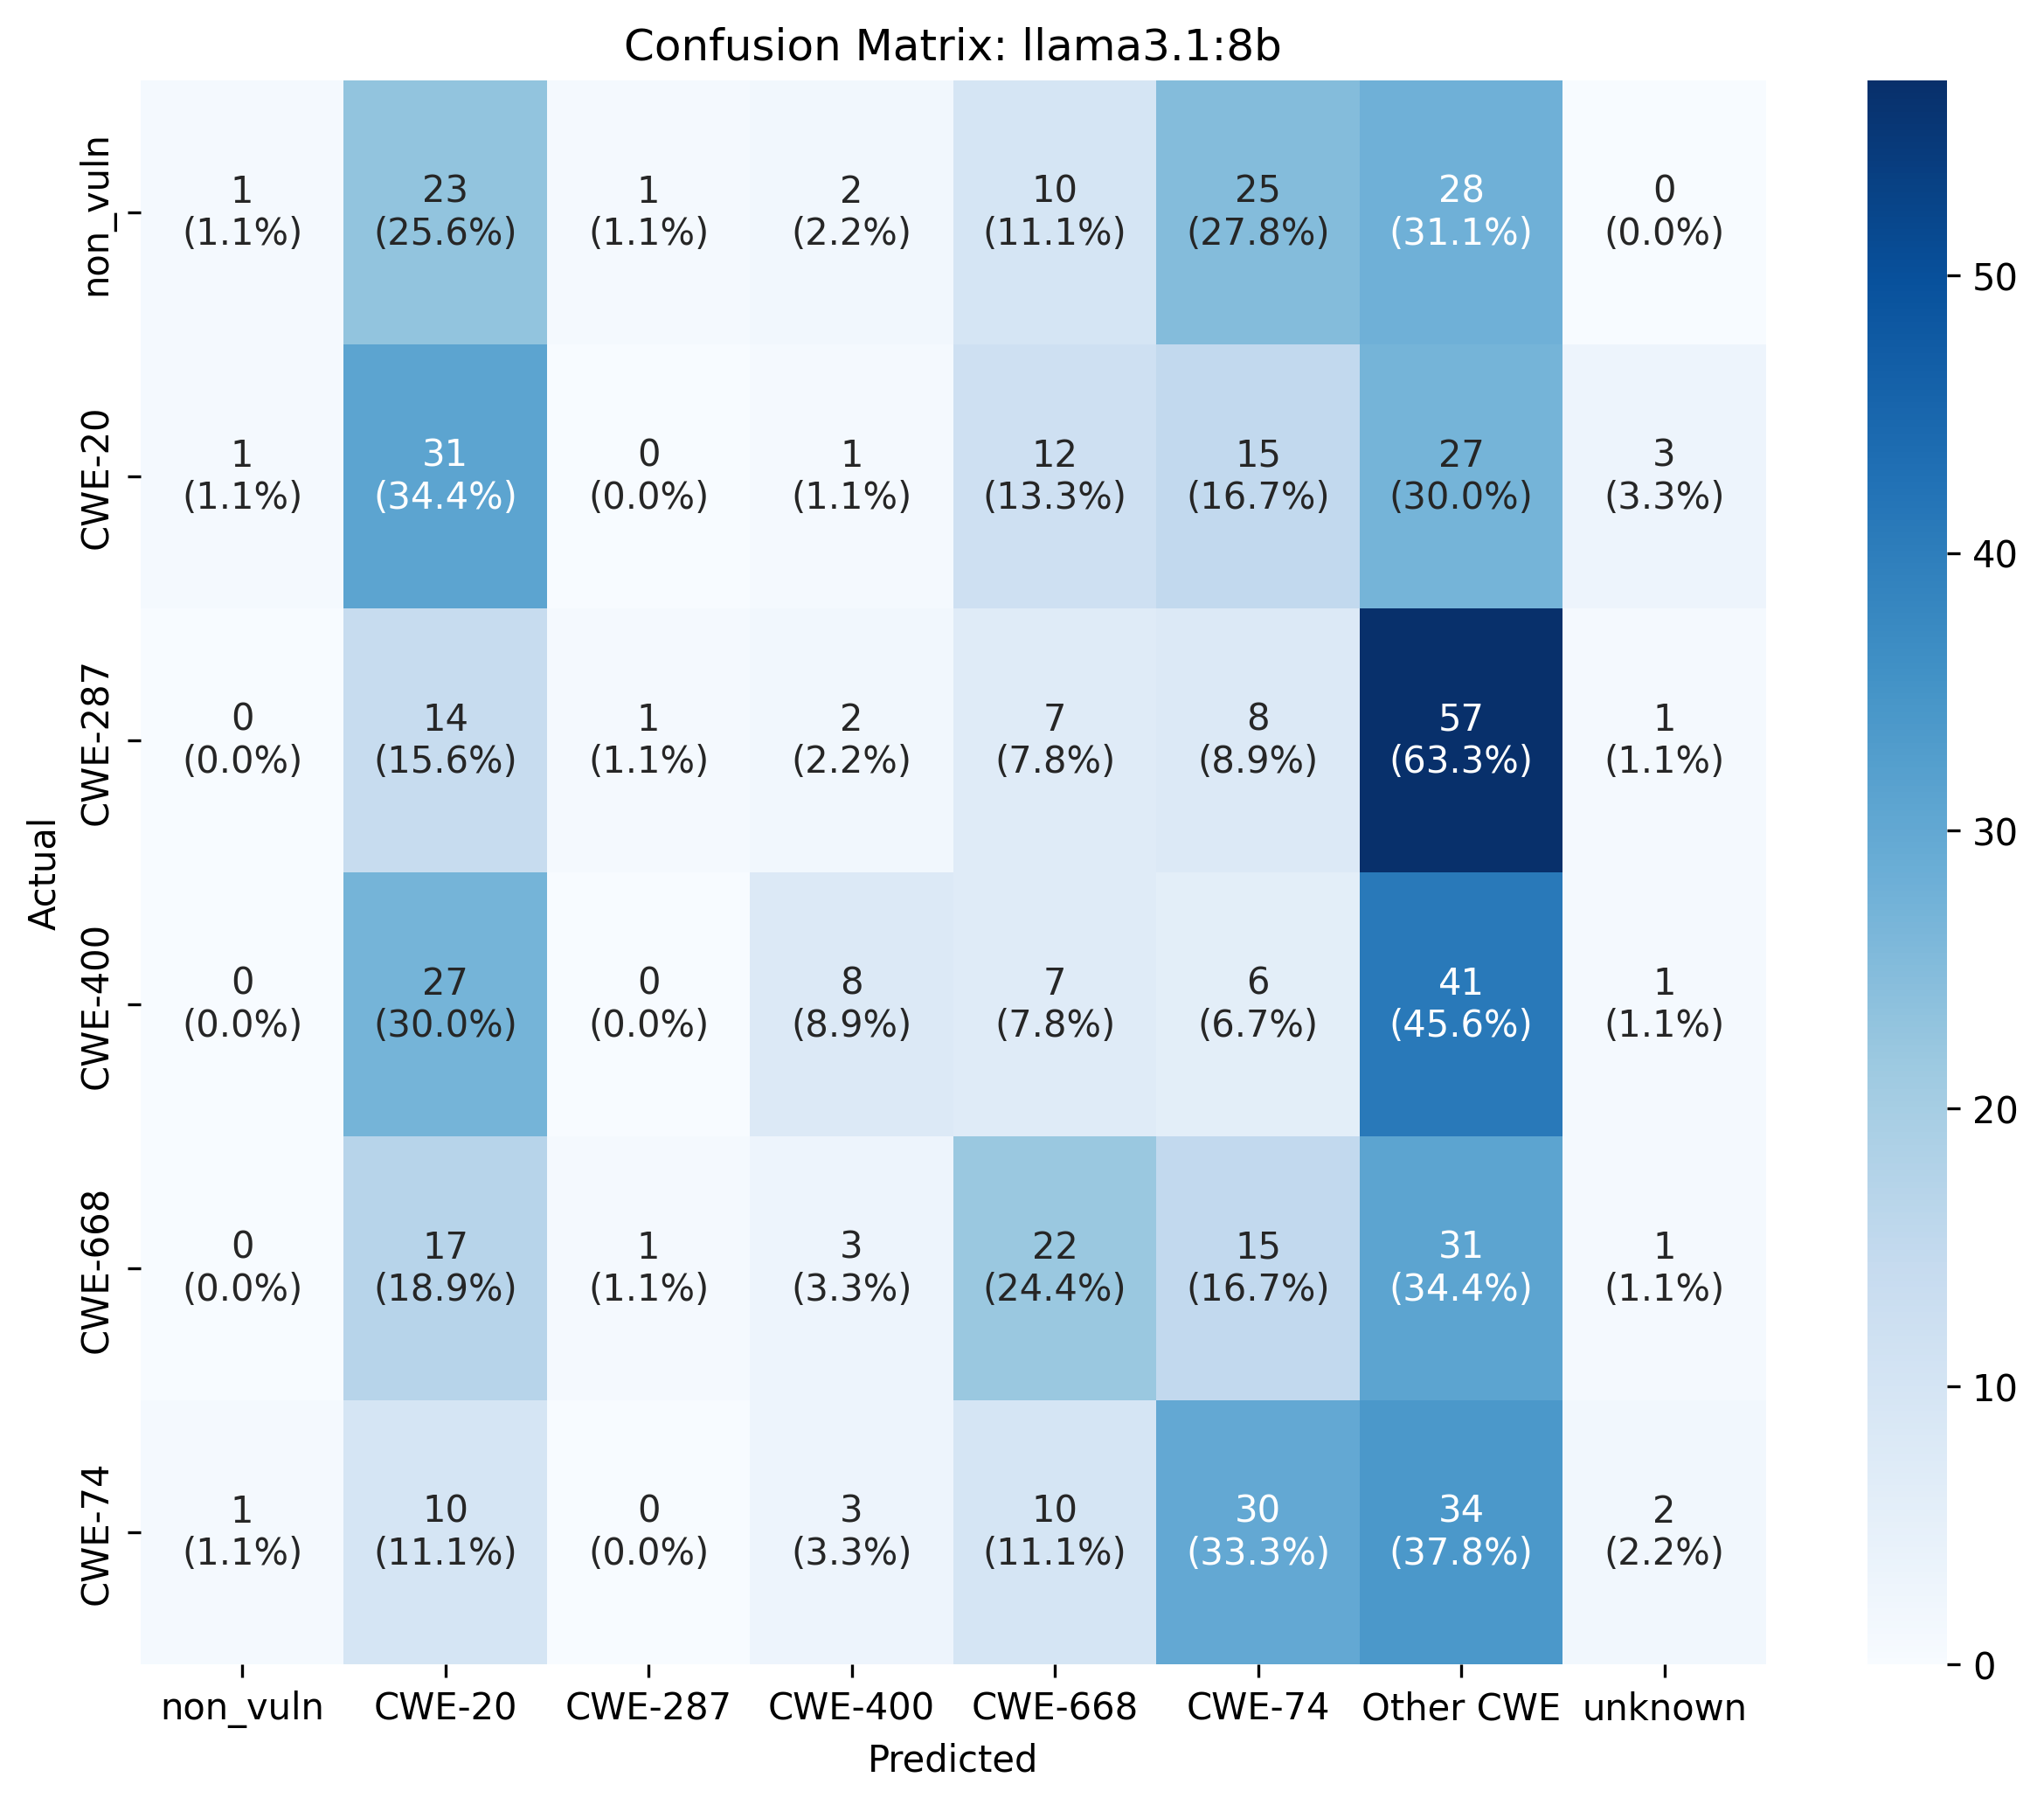

/tmp/ipykernel_3815/3726805235.py:106: RuntimeWarning: invalid value encountered in true_divide
  recall_per_class = TP / (TP + FN)  # Recall per class


Accuracy: 0.1722
Macro Precision: 0.2460
Macro Recall: 0.1292
Macro F1-score: 0.1348
non_vuln: TP=1, FP=2, FN=89, TN=448
CWE-20: TP=31, FP=91, FN=59, TN=359
CWE-287: TP=1, FP=2, FN=89, TN=448
CWE-400: TP=8, FP=11, FN=82, TN=439
CWE-668: TP=22, FP=46, FN=68, TN=404
CWE-74: TP=30, FP=69, FN=60, TN=381
Other CWE: TP=0, FP=218, FN=0, TN=322
unknown: TP=0, FP=8, FN=0, TN=532
Unique Pred Labels
['CWE-1052' 'CWE-120' 'CWE-122' 'CWE-125' 'CWE-20' 'CWE-200' 'CWE-201'
 'CWE-209' 'CWE-22' 'CWE-23' 'CWE-259' 'CWE-284' 'CWE-285' 'CWE-287'
 'CWE-319' 'CWE-321' 'CWE-325' 'CWE-326' 'CWE-327' 'CWE-352' 'CWE-397'
 'CWE-412' 'CWE-416' 'CWE-489' 'CWE-601' 'CWE-614' 'CWE-702' 'CWE-703'
 'CWE-75' 'CWE-758' 'CWE-78' 'CWE-780' 'CWE-789' 'CWE-79' 'CWE-798'
 'CWE-89' 'CWE-91' 'CWE-918' 'CWE-94' 'non_vuln' 'unknown']
pred_class_labels
['CWE-20' 'CWE-285' 'CWE-287' 'CWE-311' 'CWE-326' 'CWE-327' 'CWE-345'
 'CWE-400' 'CWE-573' 'CWE-610' 'CWE-657' 'CWE-662' 'CWE-665' 'CWE-666'
 'CWE-668' 'CWE-74' 'CWE-755' 'CWE-758'

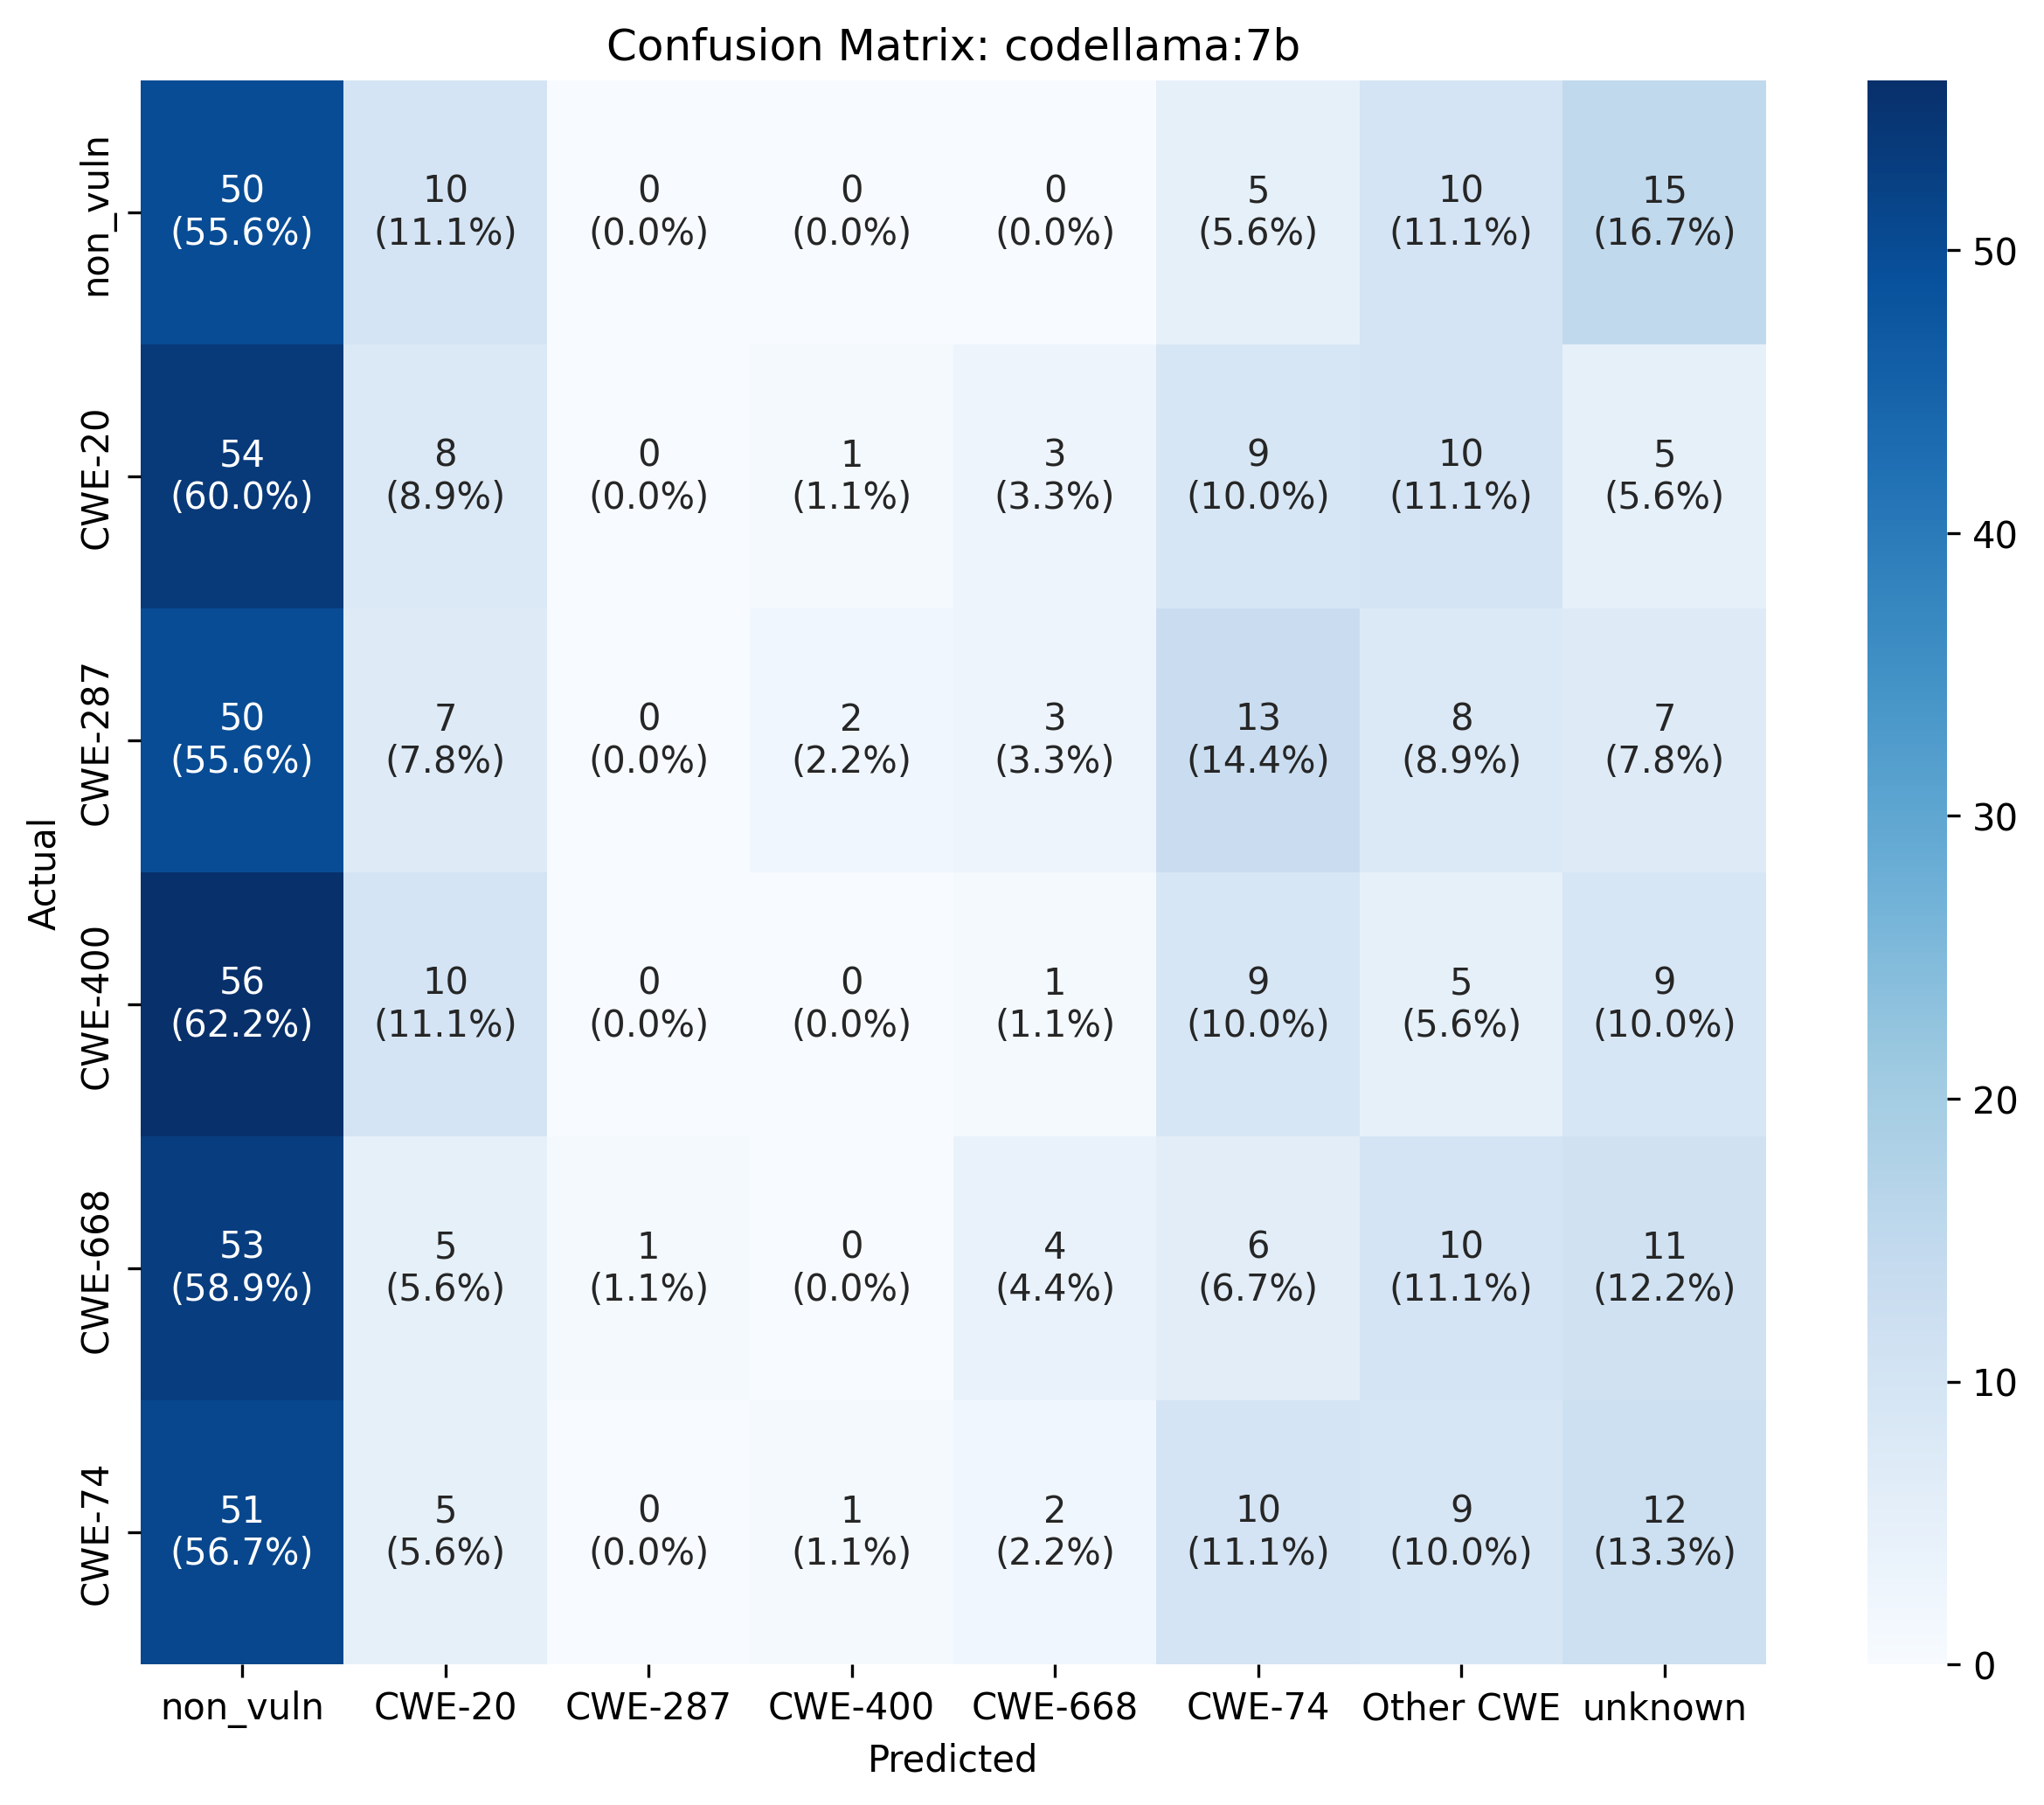

/tmp/ipykernel_3815/3726805235.py:106: RuntimeWarning: invalid value encountered in true_divide
  recall_per_class = TP / (TP + FN)  # Recall per class
/tmp/ipykernel_3815/3726805235.py:107: RuntimeWarning: invalid value encountered in true_divide
  f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)


Accuracy: 0.1333
Macro Precision: 0.1046
Macro Recall: 0.1000
Macro F1-score: 0.0731
non_vuln: TP=50, FP=264, FN=40, TN=186
CWE-20: TP=8, FP=37, FN=82, TN=413
CWE-287: TP=0, FP=1, FN=90, TN=449
CWE-400: TP=0, FP=4, FN=90, TN=446
CWE-668: TP=4, FP=9, FN=86, TN=441
CWE-74: TP=10, FP=42, FN=80, TN=408
Other CWE: TP=0, FP=52, FN=0, TN=488
unknown: TP=0, FP=59, FN=0, TN=481
Unique Pred Labels
['CWE-117' 'CWE-119' 'CWE-120' 'CWE-122' 'CWE-125' 'CWE-134' 'CWE-173'
 'CWE-190' 'CWE-20' 'CWE-200' 'CWE-208' 'CWE-209' 'CWE-22' 'CWE-259'
 'CWE-264' 'CWE-276' 'CWE-284' 'CWE-285' 'CWE-287' 'CWE-294' 'CWE-295'
 'CWE-306' 'CWE-310' 'CWE-320' 'CWE-326' 'CWE-327' 'CWE-329' 'CWE-330'
 'CWE-346' 'CWE-352' 'CWE-362' 'CWE-384' 'CWE-399' 'CWE-400' 'CWE-401'
 'CWE-415' 'CWE-416' 'CWE-427' 'CWE-434' 'CWE-469' 'CWE-476' 'CWE-494'
 'CWE-502' 'CWE-521' 'CWE-522' 'CWE-532' 'CWE-601' 'CWE-602' 'CWE-611'
 'CWE-692' 'CWE-693' 'CWE-703' 'CWE-761' 'CWE-77' 'CWE-770' 'CWE-78'
 'CWE-787' 'CWE-79' 'CWE-798' 'CWE-835' 'CWE-

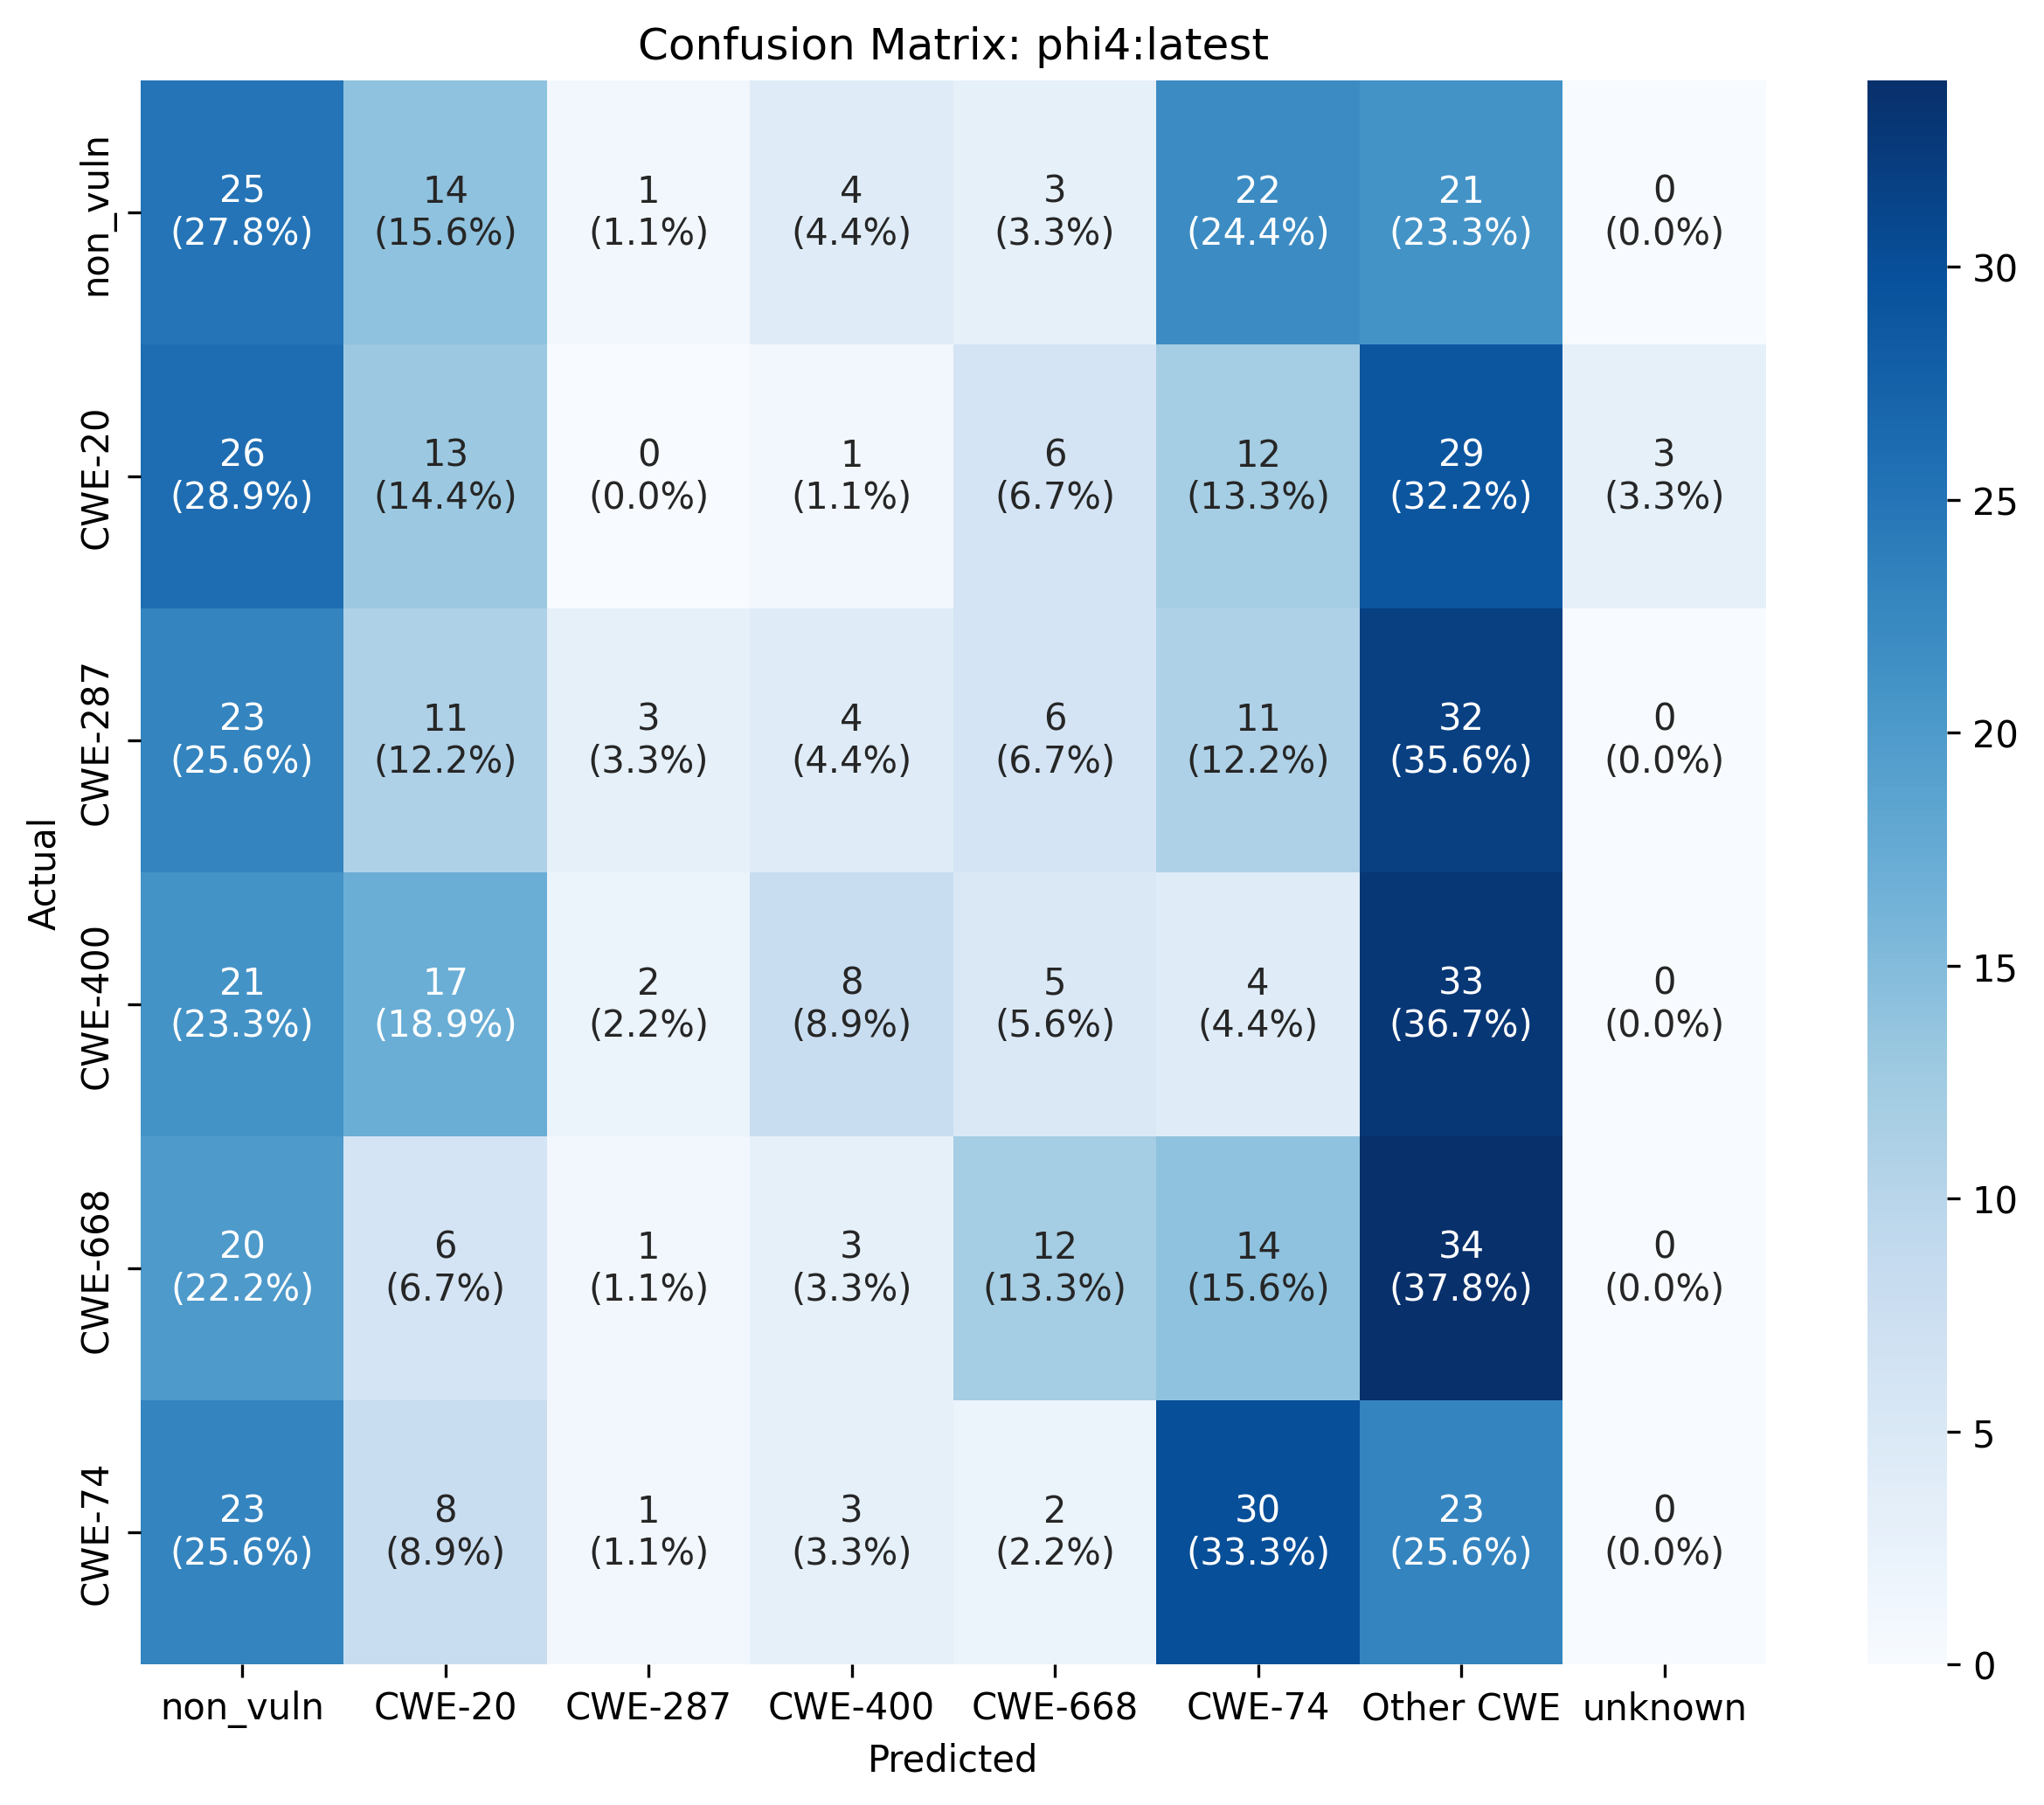

Accuracy: 0.1685
Macro Precision: 0.2210
Macro Recall: 0.1264
Macro F1-score: 0.1384
non_vuln: TP=25, FP=113, FN=65, TN=337
CWE-20: TP=13, FP=56, FN=77, TN=394
CWE-287: TP=3, FP=5, FN=87, TN=445
CWE-400: TP=8, FP=15, FN=82, TN=435
CWE-668: TP=12, FP=22, FN=78, TN=428
CWE-74: TP=30, FP=63, FN=60, TN=387
Other CWE: TP=0, FP=172, FN=0, TN=368
unknown: TP=0, FP=3, FN=0, TN=537
Unique Pred Labels
['CWE-119' 'CWE-120' 'CWE-200' 'CWE-23' 'CWE-252' 'CWE-264' 'CWE-287'
 'CWE-362' 'CWE-478' 'CWE-484' 'CWE-602' 'CWE-682' 'CWE-79' 'CWE-89'
 'non_vuln' 'unknown']
pred_class_labels
['CWE-1023' 'CWE-20' 'CWE-287' 'CWE-362' 'CWE-602' 'CWE-668' 'CWE-670'
 'CWE-74' 'CWE-754' 'non_vuln' 'unknown']
true_class_labels
['CWE-20' 'CWE-287' 'CWE-400' 'CWE-668' 'CWE-74' 'non_vuln']
pred_class_labels_filterd
['CWE-20' 'CWE-287' 'CWE-668' 'CWE-74' 'Other CWE' 'non_vuln' 'unknown']


/tmp/ipykernel_3815/3726805235.py:106: RuntimeWarning: invalid value encountered in true_divide
  recall_per_class = TP / (TP + FN)  # Recall per class


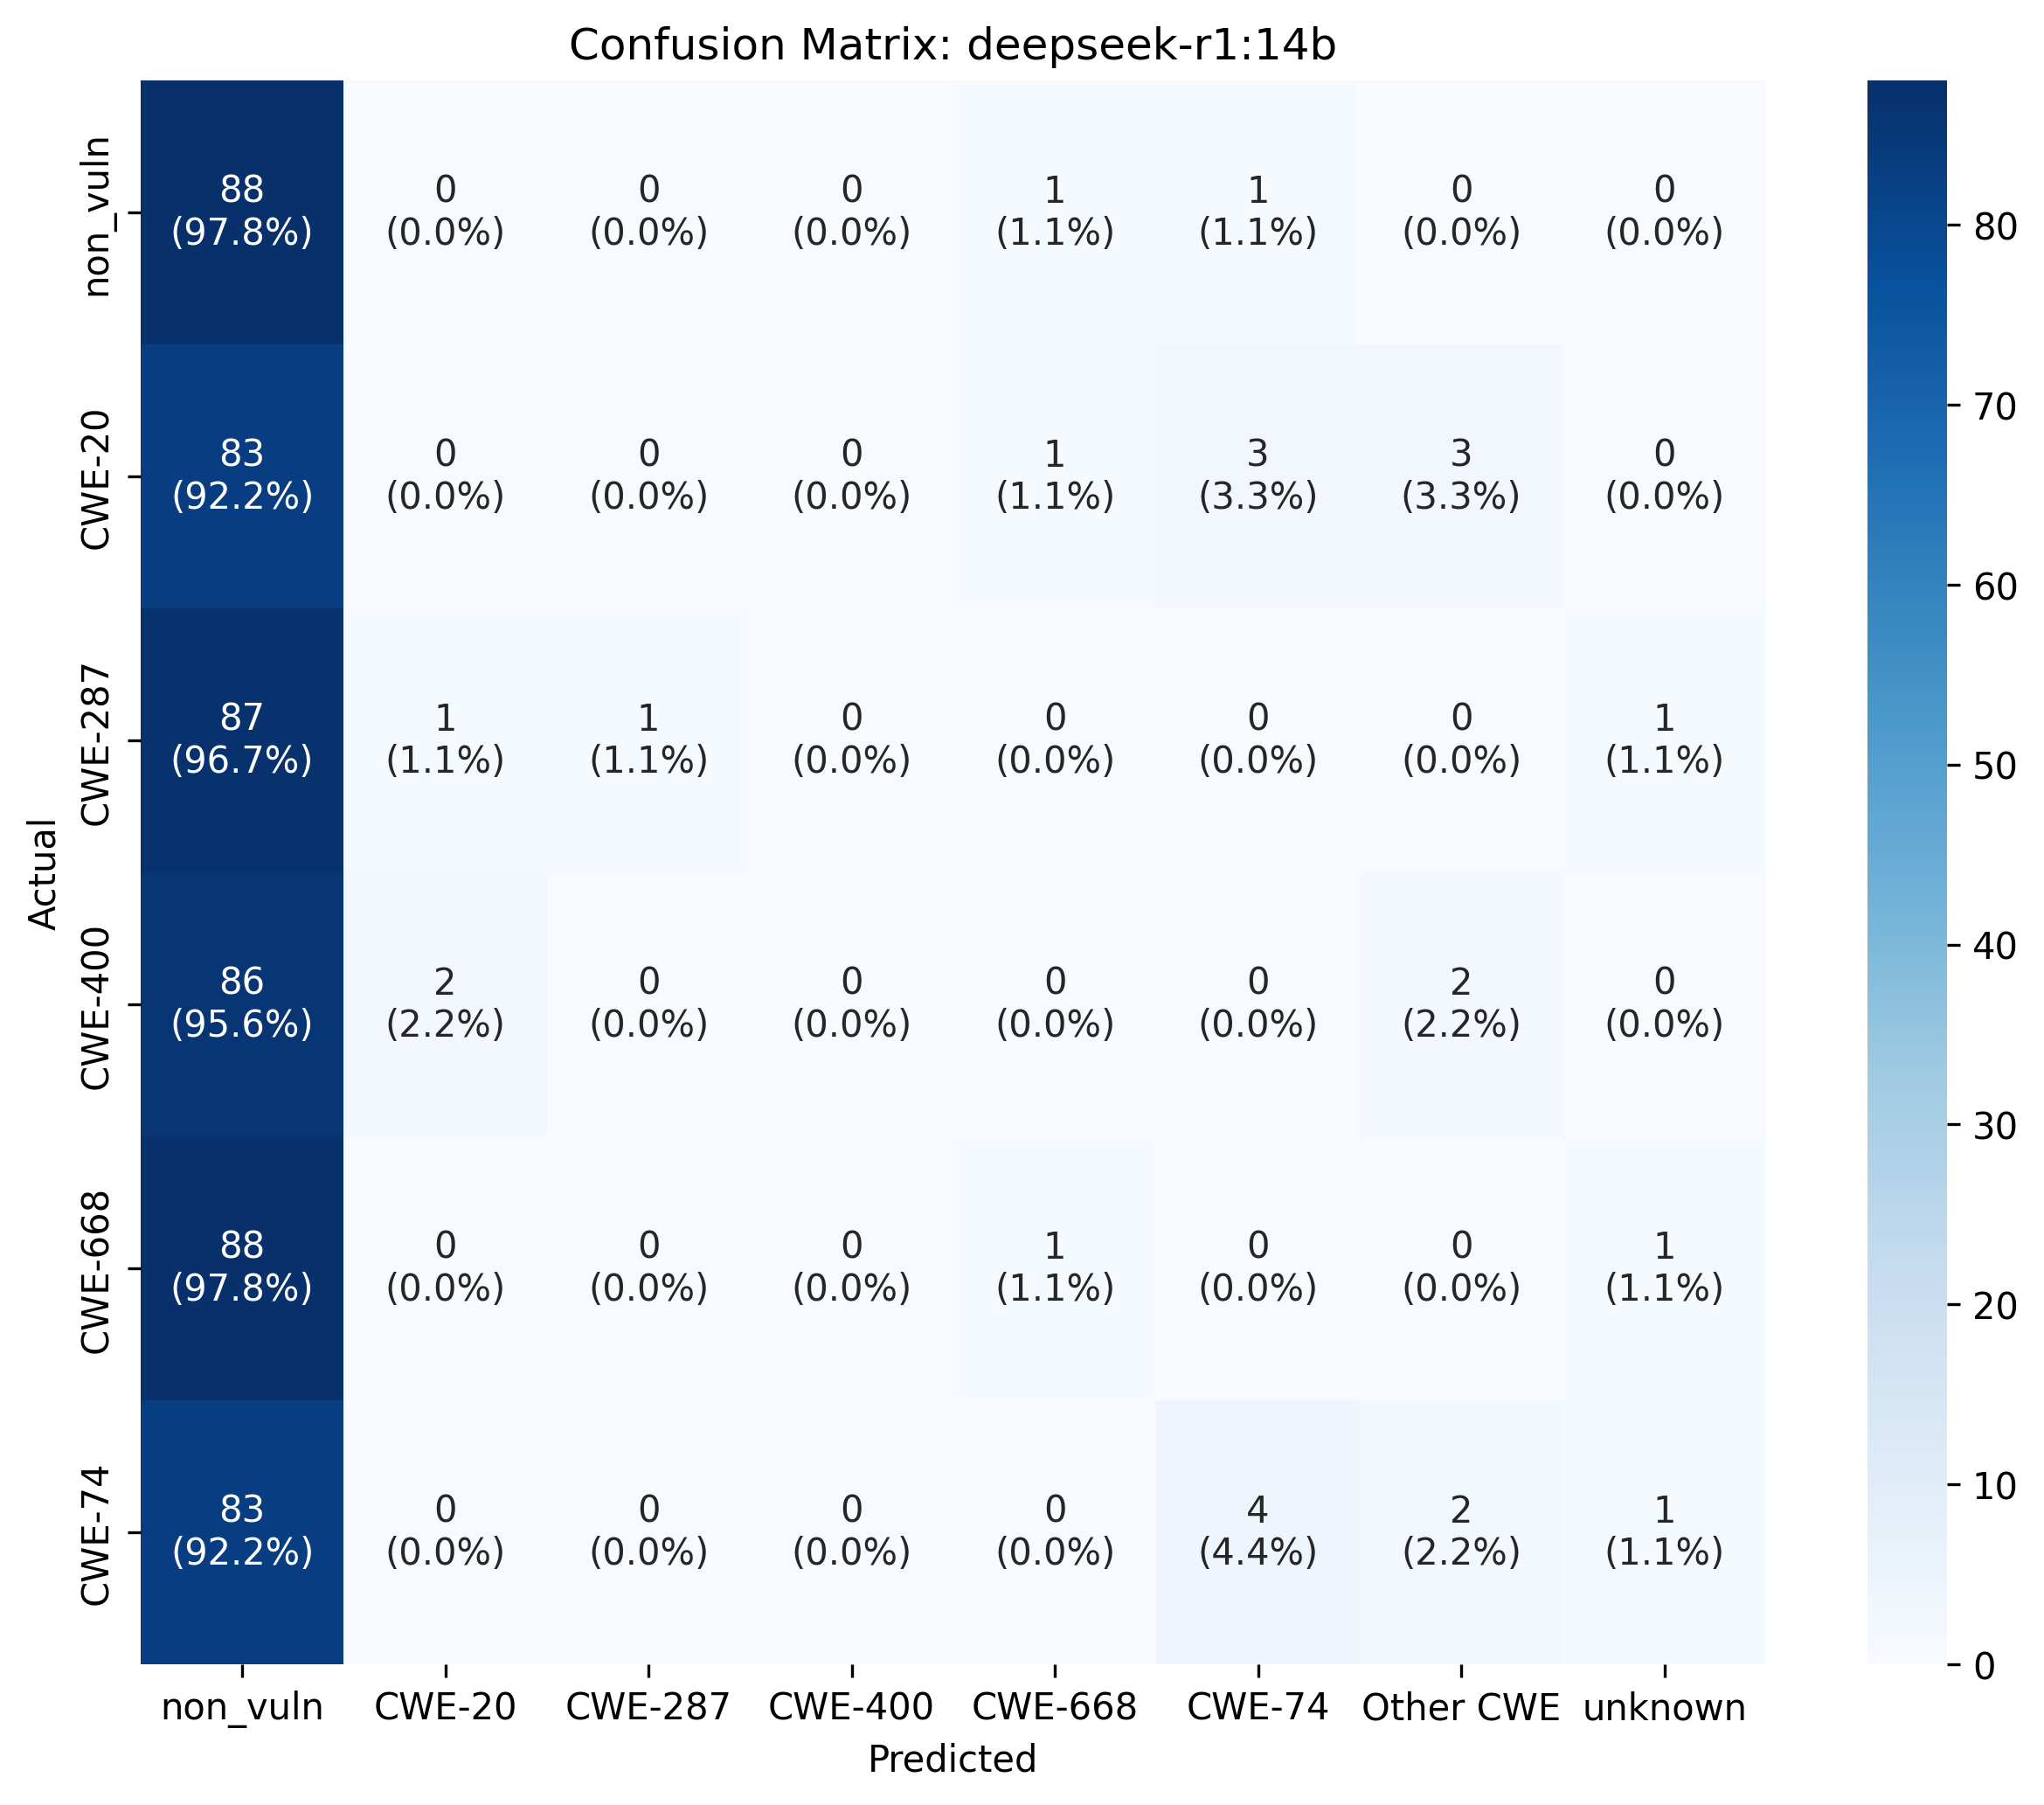

Accuracy: 0.1741
Macro Precision: 0.2505
Macro Recall: 0.1306
Macro F1-score: 0.0520
non_vuln: TP=88, FP=427, FN=2, TN=23
CWE-20: TP=0, FP=3, FN=90, TN=447
CWE-287: TP=1, FP=0, FN=89, TN=450
CWE-400: TP=0, FP=0, FN=90, TN=450
CWE-668: TP=1, FP=2, FN=89, TN=448
CWE-74: TP=4, FP=4, FN=86, TN=446
Other CWE: TP=0, FP=7, FN=0, TN=533
unknown: TP=0, FP=3, FN=0, TN=537


/tmp/ipykernel_3815/3726805235.py:105: RuntimeWarning: invalid value encountered in true_divide
  precision_per_class = TP / (TP + FP)  # Precision per class
/tmp/ipykernel_3815/3726805235.py:106: RuntimeWarning: invalid value encountered in true_divide
  recall_per_class = TP / (TP + FN)  # Recall per class
/tmp/ipykernel_3815/3726805235.py:107: RuntimeWarning: invalid value encountered in true_divide
  f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)


In [13]:
models = ['llama3.1:8b', 'codellama:7b', 'phi4:latest', 'deepseek-r1:14b']

for model in models:
    true_labels = []
    true_class_labels = []
    pred_labels = []

    for r in results:
        if r['model'] == model:
            true_labels.append(r['vuln_type'])
            true_class_labels.append(r['class'])

            vuln_exist_pred = r['result']['is_this_vuln']
            if vuln_exist_pred:
                cwe_exist_pred = r['result'].get('cwe')
                if cwe_exist_pred:
                    cwe_id = cwe_exist_pred.get('cwe_id')  # Do not set default yet
                    pred_labels.append(cwe_id if cwe_id else 'unknown')  # Ensure appending
                else:
                    pred_labels.append('unknown')  # Append even if 'cwe' is missing
            else:
                pred_labels.append('non_vuln')  # Append for non-vulnerabilities
            
    # Make dict of parent class from result
    unique_labels = np.unique(pred_labels)
    print('Unique Pred Labels')
    print(unique_labels)

    # Make a dict
    unique_cwe_class = {}
    for cwe in unique_labels:
        class_cwe = None
        if 'CWE-' in cwe:
            parents = find_parents_dict(cwe.split('-')[1])
            class_cwe = parents['Class'][-1] if parents and len(parents['Class'])>0 else None
            if class_cwe is not None:
                unique_cwe_class[cwe] = class_cwe


    unique_class_labels = np.unique(true_class_labels)            

    # Add class to pred labels
    pred_class_labels = []
    pred_class_labels_filterd = []
    for label in pred_labels:
        if label == 'non_vuln' or label == 'unknown':
            pred_class_labels.append(label)
            pred_class_labels_filterd.append(label)
        else:
            cwe = unique_cwe_class.get(label, 'unknown')
            pred_class_labels.append(cwe)

            if cwe in unique_class_labels:
                pred_class_labels_filterd.append(cwe)
            else:
                pred_class_labels_filterd.append('Other CWE')

    print('pred_class_labels')
    print(np.unique(pred_class_labels))
    print('true_class_labels')
    print(np.unique(true_class_labels))
    print('pred_class_labels_filterd')
    print(np.unique(pred_class_labels_filterd))

    # 360 for each label in true labels
    # Define all possible labels explicitly
    all_labels = ['non_vuln','CWE-20','CWE-287','CWE-400','CWE-668','CWE-74','Other CWE','unknown']

    # Compute confusion matrix with fixed class labels
    cm = confusion_matrix(true_class_labels, pred_class_labels_filterd, labels=all_labels)
    cm_tmp = cm[:-2, :]

    # Compute percentages safely
    cm_sum = cm_tmp.sum(axis=1, keepdims=True)
    cm_sum[cm_sum == 0] = 1  # Avoid division by zero
    cm_percent = cm_tmp.astype(np.float32) / cm_sum * 100

    # Create labels showing count and percentage
    labels = np.array([[f"{count}\n({perc:.1f}%)" if count > 0 else "0\n(0.0%)" 
                        for count, perc in zip(row_count, row_perc)] 
                       for row_count, row_perc in zip(cm, cm_percent)])

    # Update labels for plotting
    true_labels = ['non_vuln','CWE-20','CWE-287','CWE-400','CWE-668','CWE-74']
    pred_labels = ['non_vuln','CWE-20','CWE-287','CWE-400','CWE-668','CWE-74','Other CWE','unknown']        # Keep all predicted labels

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8), dpi=300)
    sns.heatmap(cm_tmp, annot=labels, fmt='', cmap='Blues',
                xticklabels=pred_labels,
                yticklabels=true_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {model}')
    plt.show()


    # Compute TP, FP, FN, TN
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    TN = np.sum(cm) - (TP + FP + FN)

    # Compute per-class Precision, Recall, and F1-score
    precision_per_class = TP / (TP + FP)  # Precision per class
    recall_per_class = TP / (TP + FN)  # Recall per class
    f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)

    # Handle NaN values (due to division by zero in empty classes)
    precision_per_class = np.nan_to_num(precision_per_class, nan=0.0)
    recall_per_class = np.nan_to_num(recall_per_class, nan=0.0)
    f1_per_class = np.nan_to_num(f1_per_class, nan=0.0)

    # Compute Macro Metrics (Average over all classes)
    macro_precision = np.mean(precision_per_class)
    macro_recall = np.mean(recall_per_class)
    macro_f1 = np.mean(f1_per_class)

    # Compute Accuracy
    accuracy = np.sum(TP) / np.sum(cm)

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Recall: {macro_recall:.4f}")
    print(f"Macro F1-score: {macro_f1:.4f}")

    # Print per-class TP, FP, FN, TN for reference
    for i, label in enumerate(all_labels):
        print(f"{label}: TP={TP[i]}, FP={FP[i]}, FN={FN[i]}, TN={TN[i]}")


